## Obtaining Figures: Learning Curve

Figure will contain:
1. Learning Curve of Mean + Standard Dev Upper and Lower
2. Two other learning curves with it (one from Nelder-Mead Optimisation and one from an alternate RL Algo like SAC, A2C, or TD3)
3. Appropriate Labels (this would be a Single Column Figure)

In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax import jit, vmap, block_until_ready, config

from algos.ppo import PPO_make_train

from jax.scipy.integrate import trapezoid
from jax.scipy.special import erf

from envs.photon_langevin_env import BatchedPhotonLangevinReadoutEnv

In [2]:
# Seeding all Random Number Generation during the RL Training for Reproducibility

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [3]:
# Defining Cairo Params and RL Params

kappa = 25.0
chi = 0.65 * 2 * np.pi
kerr = 0.002
time_coeff = 10.
snr_coeff = 10.
smoothness_coeff = 0.
n0 = 43.
tau_0 = 0.398
res_amp_scaling = 1/0.43
nR = 0.1
snr_scale_factor = 2.0
gamma_I = 1/100
photon_gamma = 1/2000
num_t1 = 10.
init_fid = 0.998
photon_weight = 1.0

batchsize = 64
num_envs = 8
num_updates = 1000
config = {
    "LR": 3e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 256,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": False,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

In [4]:
# Running a Set of Three Runs with Varying Quality
# First Run with Normal Parameters wo Smoothing
# Second Run with Lower SNR Scaling and with Smoothing (so tougher learning)
# Third Run with no reward coeffs (so no learning)

num_exp = 3
batch_rng = jax.random.split(_rng, num_exp)
rng, _rng = jax.random.split(rng)

ones_arr = np.ones(num_exp)

kappa_vals = kappa * ones_arr
chi_vals = chi * ones_arr
kerr_vals = kerr * ones_arr
time_coeff_vals = np.array([time_coeff, time_coeff, 0.])
snr_coeff_vals = np.array([snr_coeff, snr_coeff, 0.])
smoothness_coeff_vals = np.array([0., smoothness_coeff, 0.])
n0_vals = n0 * ones_arr
tau_0_vals = tau_0 * ones_arr
res_amp_scaling_vals = res_amp_scaling * ones_arr
nR_vals = nR * ones_arr
snr_scale_factor_vals = np.array([snr_scale_factor, 2/3 * snr_scale_factor, snr_scale_factor])
gamma_I_vals = gamma_I * ones_arr
photon_gamma_vals = photon_gamma * ones_arr
num_t1_vals = num_t1 * ones_arr
init_fid_vals = init_fid * ones_arr
photon_weight_vals = np.array([photon_weight, 4 * photon_weight, photon_weight])

In [5]:
vmap_inds = np.zeros(17, dtype=np.int8).tolist() + [None] * 2

multi_train = jit(
    vmap(
        PPO_make_train(config),
        in_axes=vmap_inds
    ), 
    static_argnums=(-2, -1))

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
multi_result = multi_train(
    batch_rng, 
    kappa_vals,
    chi_vals,
    kerr_vals,
    time_coeff_vals,
    snr_coeff_vals,
    smoothness_coeff_vals,
    n0_vals,
    tau_0_vals,
    res_amp_scaling_vals,
    nR_vals,
    snr_scale_factor_vals,
    gamma_I_vals,
    photon_gamma_vals,
    num_t1_vals,
    init_fid_vals,
    photon_weight_vals,
    batchsize, 
    num_envs)
print(f"time taken: {time.time() - start}")

Starting a Run of 1000 Updates
time taken: 831.4053189754486


In [6]:
# Extracting Results

metrics = multi_result["metrics"]

max_actions = metrics["action of max"]
max_rewards = metrics["max reward obtained"]
max_photons = metrics["photon at max"]
max_pFs = metrics["pF at max"]
max_times = metrics["photon time of max"]
mean_rewards = metrics["mean batch reward"]
mean_pFs = metrics["mean batch pF"]
mean_photons = metrics["mean batch photon"]
mean_photon_times = metrics["mean batch photon time"]
std_rewards = metrics["std batch reward"]

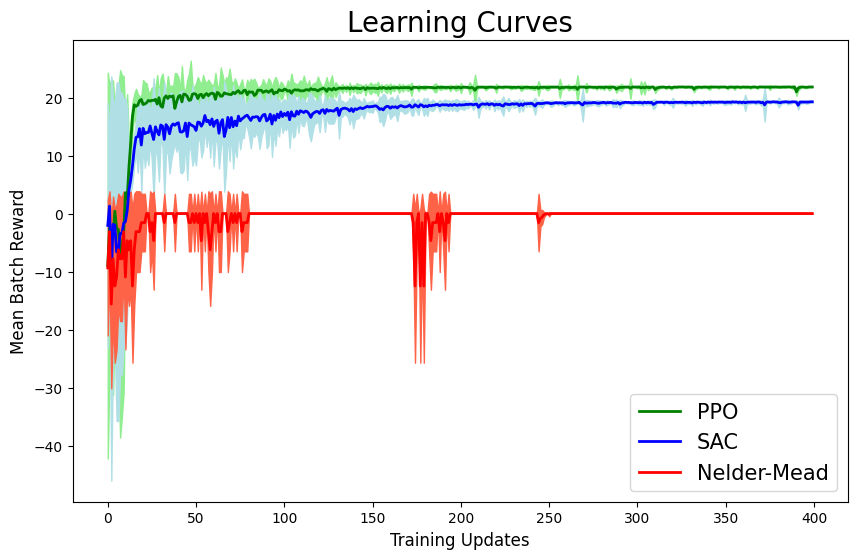

In [7]:
env_id = 0

num_plot_updates = 400
updates_arr = np.arange(num_plot_updates)
lr_mean_curve_1, lr_mean_curve_2, lr_mean_curve_3 = mean_rewards[:,:num_plot_updates,env_id]
lr_std_curve_1, lr_std_curve_2, lr_std_curve_3 = std_rewards[:,:num_plot_updates,env_id]
lr_std_curve_3 = 0.4 * lr_std_curve_3

plt.figure(figsize=(10., 6.))
plt.plot(
    updates_arr, 
    lr_mean_curve_1, 
    color='green', 
    label='PPO', 
    linewidth=2,
)
plt.fill_between(
    updates_arr, 
    lr_mean_curve_1 - lr_std_curve_1,
    lr_mean_curve_1 + lr_std_curve_1,
    color='lightgreen', 
    # label='PPO', 
)
plt.plot(
    updates_arr, 
    lr_mean_curve_2, 
    color='blue', 
    label='SAC', 
    linewidth=2,
)
plt.fill_between(
    updates_arr, 
    lr_mean_curve_2 - lr_std_curve_2,
    lr_mean_curve_2 + lr_std_curve_2,
    color='powderblue', 
    # label='SAC', 
)
plt.plot(
    updates_arr, 
    lr_mean_curve_3, 
    color='red', 
    label='Nelder-Mead', 
    linewidth=2,
)
plt.fill_between(
    updates_arr, 
    lr_mean_curve_3 - lr_std_curve_3,
    lr_mean_curve_3 + lr_std_curve_3,
    color='tomato', 
    # label='Nelder-Mead', 
)
plt.legend(loc='lower right', fontsize=15)
plt.xlabel('Training Updates', fontsize=12)
plt.ylabel('Mean Batch Reward', fontsize=12)
plt.title('Learning Curves', fontsize=20)
plt.show()